In [2]:
import os, csv, math
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import keras_cv
import keras
import keras.backend as K
import tensorflow as tf

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.utils import make_grid
from torchvision.ops import Permute

### ⚙️ Config + setting up utilities

In [3]:
from config import CFG
from data import ICImagesDataset

import wandb
from wandb.integration.keras import WandbMetricsLogger

## 🏞️ Plotting utilities

In [12]:
def plot_loss(hist, outfile=None):
    plt.grid(ls=':')
    plt.plot(np.arange(len(hist['loss'])), hist['loss'], label='train loss')
    plt.plot(np.arange(len(hist['loss'])), hist['val_loss'], label='val loss')
    plt.legend()
    if outfile:
        plt.savefig(outfile, dpi=150)
    plt.show()    

def plot_acc(hist, outfile=None):
    plt.grid(ls=':')
    plt.plot(np.arange(len(hist['accuracy'])), hist['accuracy'], label='train accuracy')
    plt.plot(np.arange(len(hist['accuracy'])), hist['val_accuracy'], label='val accuracy')
    plt.legend()
    if outfile:
        plt.savefig(outfile, dpi=150)
    plt.show()

## 📁 Load train + validation dataset (as `torch.utils.data.Dataset`)

In [4]:
move_channels_inward_fn = Permute([1, 2, 0])

# training data
train_dataset = ICImagesDataset(
    annotations=CFG.annotations_fname.format("train"),
    directory=CFG.images_dirname.format("train"),
    transform=move_channels_inward_fn
)
train_dataloader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, shuffle=True)

# validation data
val_dataset = ICImagesDataset(
    annotations=CFG.annotations_fname.format("val"),
    directory=CFG.images_dirname.format("val"),
    transform=move_channels_inward_fn
)
val_dataloader = DataLoader(val_dataset, batch_size=CFG.val_batch_size, shuffle=True)

## 🤖📉 Build and train models

In [5]:
train_history = {}

### Approach 1 "Post-VGG": VGG feature extractor + Dense model on extracted features

In [6]:
# use the VGG convolutional base to extract features
def vgg_extract_features(conv_base, dataloader):
    all_features = []; all_labels = []
    for images, labels in dataloader:
        # pdb.set_trace()
        preprocessed = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed, verbose=0)        
        all_features.append(features)
        all_labels.append(labels)

    return np.concatenate(all_features), np.concatenate(all_labels)

In [7]:
vgg_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(CFG.input_shape, CFG.input_shape, 3)
)
print(vgg_base.summary())

# vectorize data into VGG-friendly format
vgg_extracted_train_features, vgg_train_labels = vgg_extract_features(vgg_base, train_dataloader)
vgg_extracted_val_features, vgg_val_labels = vgg_extract_features(vgg_base, val_dataloader)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
# ===== build Post-VGG classifier =====
inputs = keras.Input(shape=(2, 2, 512))  # this is the output shape of VGG's last layer
x = keras.layers.Flatten()(inputs)  # this will convert to 2*2*512=2048 dims
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.7)(x)  # regularization
outputs = keras.layers.Dense(CFG.label_count, activation="softmax")(x)  # output is softmax over all vendors
post_vgg_model = keras.Model(inputs, outputs, name="post-vgg-classifier")

# ===== set up for training (these baseline training runs don't log to wandb) =====
post_vgg_model.compile(
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/post-vgg-model.keras",
        save_best_only=True,
        monitor="val_accuracy"
    )
]

# run training
history_post_vgg = post_vgg_model.fit(
    vgg_extracted_train_features,
    vgg_train_labels,
    validation_data = (vgg_extracted_val_features, vgg_val_labels),
    callbacks=callbacks,
    epochs=50
)

# save loss for visualizing later
train_history['post-vgg'] = history_post_vgg.history

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1234 - loss: 74.5165 - val_accuracy: 0.3146 - val_loss: 30.2445
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2802 - loss: 44.9040 - val_accuracy: 0.3847 - val_loss: 27.2054
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3395 - loss: 34.0509 - val_accuracy: 0.3536 - val_loss: 24.9085
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3840 - loss: 26.8083 - val_accuracy: 0.4128 - val_loss: 22.1907
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4313 - loss: 22.7437 - val_accuracy: 0.4143 - val_loss: 18.6159
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4680 - loss: 19.3093 - val_accuracy: 0.4642 - val_loss: 18.9343
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4542 - loss: 17.1922 - val_accuracy: 0.4221 - val_loss: 18.5397
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4882 - loss: 14.7970 - v

### Approach 2 "Post-VGG-Aug": Same as approach 1 but with data augmentation

In [15]:
# make sure backbone layers are frozen so we don't end up fine-tuning
vgg_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False
)
vgg_base.trainable = False

# set up augmentation pipeline
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

#  ==== build model: augmentation -> VGG -> dense classifier ====
inputs = keras.Input(shape=(CFG.input_shape, CFG.input_shape, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = vgg_base(x)
x = keras.layers.Flatten()(x)
# use Xavier initialization this gime
x = keras.layers.Dense(256, kernel_initializer=keras.initializers.GlorotNormal(seed=42))(x)
# use higher dropout to generalize even better
x = keras.layers.Dropout(0.65)(x)
outputs = keras.layers.Dense(CFG.label_count, activation="softmax")(x)

post_vgg_aug = keras.Model(inputs, outputs, name="post-vgg-aug-model")
post_vgg_aug.compile(
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [18]:
# launch training
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/post-vgg-aug-model.keras",
        save_best_only=True,
        monitor="val_accuracy"
    )
]
history_post_vgg_aug = post_vgg_aug.fit(
    train_dataloader,
    epochs=50,
    validation_data=val_dataloader,
    callbacks=callbacks
)

# save for analysis
train_history['post-vgg-aug'] = history_post_vgg_aug.history

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - accuracy: 0.5113 - loss: 3.1147 - val_accuracy: 0.4938 - val_loss: 3.3805
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - accuracy: 0.5185 - loss: 3.0557 - val_accuracy: 0.4875 - val_loss: 3.3357
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 196ms/step - accuracy: 0.5068 - loss: 3.1290 - val_accuracy: 0.5265 - val_loss: 3.0282
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 195ms/step - accuracy: 0.5188 - loss: 3.0393 - val_accuracy: 0.5234 - val_loss: 3.1133
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 197ms/step - accuracy: 0.5061 - loss: 3.1127 - val_accuracy: 0.5187 - val_loss: 3.2607
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step - accuracy: 0.5096 - loss: 3.0993 - val_accuracy: 0.5109 - val_loss: 3.0620
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 195ms/step - accuracy: 0.5052 - loss: 3.0944 - val_accuracy: 0.5093 - val_loss: 3.1911
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 199ms/step - accuracy: 0.5243 - loss: 2

### Approach 3 "VGG-FT-Aug": Fine-tune last few layers of VGG + train classification head

In [20]:
train_config = {
    'num_unfrozen_layers': 6,
    'dropout_ratio': 0.65,
    'lr': 1e-5,
    'weight_decay': None,
    'rescaling': True,
    'epochs': 100
}

vgg_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False
)

# turn on training for last few layers
vgg_base.trainable = True
for layer in vgg_base.layers[:-train_config['num_unfrozen_layers']]:
    # make all non-trainable, except last few
    layer.trainable = False

# set up augmentation pipeline
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

# build model: augmentation -> VGG -> dense classifier
inputs = keras.Input(shape=(CFG.input_shape, CFG.input_shape, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
if train_config['rescaling']:
    x = keras.layers.Rescaling(1./255)(x)
x = vgg_base(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, kernel_initializer=keras.initializers.GlorotNormal(seed=42))(x)
x = keras.layers.Dropout(train_config['dropout_ratio'])(x)
outputs = keras.layers.Dense(CFG.label_count, activation="softmax")(x)

In [22]:
vgg_ft = keras.Model(inputs, outputs, name="vgg-ft-model")
vgg_ft.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=train_config['lr'], weight_decay=train_config['weight_decay']),
    metrics=["accuracy"]
)

wandb.init(
    project="ic-chip-net",
    config=train_config
)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/vgg-ft-model.keras",
        save_best_only=True,
        monitor="val_accuracy"
    ),
    WandbMetricsLogger()
]

# start training
history_vgg_ft = vgg_ft.fit(
    train_dataloader,
    epochs=train_config['epochs'],
    validation_data=val_dataloader,
    callbacks=callbacks
)

train_history['vgg-ft'] = history_vgg_ft.history

wandb: Currently logged in as: muhammadali. Use `wandb login --relogin` to force relogin


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.0736 - loss: 3.8735

wandb: ERROR Unable to log learning rate.


140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 313ms/step - accuracy: 0.0738 - loss: 3.8710 - val_accuracy: 0.2461 - val_loss: 2.6546
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 323ms/step - accuracy: 0.1873 - loss: 2.8831 - val_accuracy: 0.3505 - val_loss: 2.3408
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 322ms/step - accuracy: 0.2919 - loss: 2.4839 - val_accuracy: 0.3925 - val_loss: 2.1777
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - accuracy: 0.3367 - loss: 2.3219 - val_accuracy: 0.4174 - val_loss: 2.0031
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 325ms/step - accuracy: 0.3902 - loss: 2.1590 - val_accuracy: 0.4299 - val_loss: 1.9344
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 312ms/step - accuracy: 0.4293 - loss: 2.0240 - val_accuracy: 0.4704 - val_loss: 1.8768
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 312ms/step - accuracy: 0.4332 - loss: 1.9409 - val_accuracy: 0.4860 - val_loss: 1.7512
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 312ms/step - accuracy: 0.4822 - loss: 1.839

## ⚖️ Comparing training process of all approaches

In [30]:
train_history['post-vgg'].keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

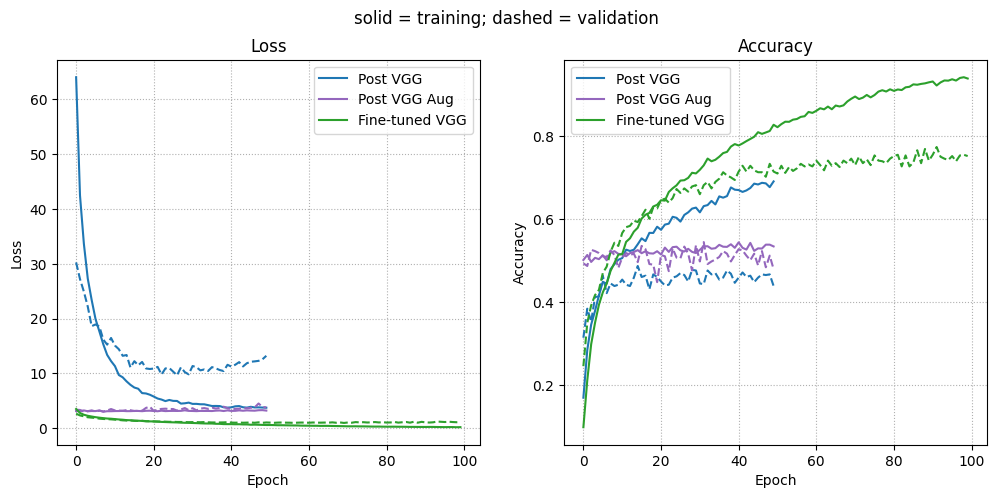

In [43]:
approaches = ['post-vgg', 'post-vgg-aug', 'vgg-ft']
labels = ['Post VGG', 'Post VGG Aug', 'Fine-tuned VGG']
colors = ['tab:blue', 'tab:purple', 'tab:green']

f, axs = plt.subplots(1, 2, figsize=(12,5))
for i, app in enumerate(approaches):
    axs[0].plot(np.arange(len(train_history[app]['loss'])), train_history[app]['loss'],
                label=labels[i], color=colors[i])
    axs[0].plot(np.arange(len(train_history[app]['val_loss'])), train_history[app]['val_loss'],
                ls='--', color=colors[i])
    
    axs[1].plot(np.arange(len(train_history[app]['accuracy'])), train_history[app]['accuracy'],
                label=labels[i], color=colors[i])
    axs[1].plot(np.arange(len(train_history[app]['val_accuracy'])), train_history[app]['val_accuracy'],
                ls='--', color=colors[i])

axs[0].set_ylabel('Loss')
axs[1].set_ylabel('Accuracy')
axs[0].set_title('Loss')
axs[1].set_title('Accuracy')
plt.suptitle('solid = training; dashed = validation')

for ax in axs:
    ax.legend()
    ax.grid(ls=':')
    ax.set_xlabel('Epoch')

plt.savefig('train-logs.png', dpi=300, bbox_inches='tight')